In [1]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.5 MB/s eta 0:00:00


In [2]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=9b4a7bd1a033be3accf2b7cec829a27d3d5e47df6e768c72fa1d8f9c06483be1
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import ranksums
from sklearn.feature_selection import RFECV
#-----------------model for survival-----------------------------------
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
#------------------------------------------------------------------------
from sklearn.inspection import permutation_importance
import statistics
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines.statistics import pairwise_logrank_test
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn.preprocessing import StandardScaler

In [4]:
def C_indicator(model, x_train, y_train, y_trstatus, y_trtime, x_test, y_test, y_testatus, y_tetime):
  
  #modeling
  model.fit(x_train, y_train)

  #train
  train_pre = model.predict(x_train)
  tr_c_index, tr_iccd, tr_idcd, tr_iti_risk, tr_iti_time = concordance_index_censored(y_trstatus > 0, y_trtime, train_pre)
  tr_c_ipcw, tr_pccd, tr_pdcd, tr_pti_risk, tr_pti_time = concordance_index_ipcw(y_train, y_train, train_pre)
  
  #test
  test_pre = model.predict(x_test)
  te_c_index, te_iccd, te_idcd, te_iti_risk, te_iti_time = concordance_index_censored(y_testatus > 0, y_tetime, test_pre)
  te_c_ipcw, te_pccd, te_pdcd, te_pti_risk, te_pti_time = concordance_index_ipcw(y_train, y_test, test_pre)

  #combine
  result = {
        "C-index":[tr_c_index, te_c_index],
        "C-ipcw":[tr_c_ipcw, te_c_ipcw]
  }

  indicator = pd.DataFrame(result)
  indicator.index = ['training', 'test']
  indicator.round(3)
  print(indicator)

In [5]:
def train_mcv(suv_model, x_train, y_train, ystatus_train, ytime_train, cv):
  
  train_model = suv_model.fit(x_train, y_train)
  train_pre = train_model.predict(x_train)
  tr_c_index, tr_iccd, tr_idcd, tr_iti_risk, tr_iti_time = concordance_index_censored(ystatus_train > 0, ytime_train, train_pre)

  val_score = my_cross_val(suv_model, x_train, y_train, ystatus_train, ytime_train, cv)

  print('train cindex:', tr_c_index)
  print('cross validation score:', val_score)

In [6]:
def my_cross_val(model, x_train, y_train, ystatus_train, ytime_train, cv):

  cvs = 0
  record = []
  num_val_samples = len(x_train)//cv
  cols = x_train.columns

  for i in range(cv):

      val_data = x_train[i*num_val_samples : (i+1)*num_val_samples]
      val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]
      
      remaining_data = np.concatenate( 
                          [x_train[: i*num_val_samples],
                          x_train[(i+1)*num_val_samples :]],
                          axis = 0)
      remaining_targets = np.concatenate(
                          [y_train[: i*num_val_samples],
                          y_train[(i+1)*num_val_samples :]],
                          axis = 0)
      
      val_ystatus = ystatus_train[i*num_val_samples : (i+1)*num_val_samples]
      val_ytime = ytime_train[i*num_val_samples : (i+1)*num_val_samples]

      remaining = pd.DataFrame(remaining_data, columns=cols)
      val = pd.DataFrame(val_data, columns=cols)

      now_score = mcs_c_index_scoring(model, remaining, remaining_targets, val_data, val_ystatus, val_ytime)
      record.append(now_score)
  
  for i in record:
    cvs += (i/cv)
  
  return cvs

In [7]:
def mcs_c_index_scoring(model, x_train, y_train, x_val, ystatus_val, ytime_val):
  model.fit(x_train, y_train)
  pre = model.predict(x_val)
  a, b, c, d, e = concordance_index_censored(ystatus_val>0, ytime_val, pre)

  return a

In [8]:
def km_logrank(inter, X_train, y_train_struct):

  gene = X_train[inter]
  median = statistics.median(gene)
  for i in X_train.index:
    if gene.loc[i] > median:
      gene.loc[i] = "High"
    else:
      gene.loc[i] = "Low"

  for expression in ("High","Low"):
    mask_treat = gene == expression
    time_treat, survival_prob_treat = kaplan_meier_estimator(y_train_struct["Status"][mask_treat],y_train_struct["Survival"][mask_treat])
    plt.step(time_treat, survival_prob_treat, where="post",label=expression)
  
  log_rank = pairwise_logrank_test(y_train_struct["Status"], gene, y_train_struct["Survival"])
  print(log_rank.summary)

  plt.ylabel("est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.legend(loc="best")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
raw_data = pd.read_excel("/content/drive/MyDrive/tcga_stad.xlsx",sheet_name="all")

# **preprocessing**

In [11]:
x = raw_data.iloc[:,0:-3]
y_recur = raw_data.iloc[:,-1]
y_time = raw_data.iloc[:,-2]
y_status = raw_data.iloc[:,-3]
y_label = raw_data.iloc[:,-3:-1]

In [12]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(x, y_recur):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
  y_train, y_test = y_recur[train_index], y_recur[test_index]

TRAIN: [ 29 231  16 225  23 161 246 130  51 142 146  48  78  35 236  65 119 238
  85 120 129 207 196 235 123 117 143 138  68 202 124 212  25 171 220  69
 166 191 111  37  74  75   6  92  34 148 184 193  76  13  88 113  66 158
  71 188 118  59 105 114 182 131 134   7   5 228 179 232   1 180 243 189
   8 122 127 164   4  72 100 205   9 157 151 237  39  64 170  62  58 121
  19 167 197  89  12 219 149  97  56 139 140 227 109 147 210 185  11  22
  47  70 154 145  17 208 175 165 233  20  91 178 223  30  87 187  31 115
   2  81 194  98 245  73 209 242  40  60 195 136  36 150 215   3  42  52
 204 192 155 203 201 133 226 186 135 102 213  99  55 229  61  32  21 176
 156  54  38  24 224 106  96 153  90  46] TEST: [241  79   0 216  18  84 110  45 211 239 217 160  33  80 181 125  95 159
 116  94 152  10  50 108 169 199  15  93 183  14 112  63 126 172 206  83
  67 198 173 174 230  86 222 221 200 218 137 163 128  41  44 104  28 101
 168 103 107 141  53  82 132 144 244  26 162  77  49 240 177 214  43 

In [13]:
df_ranksum = pd.concat([X_train,y_train], axis = 1)
filter = df_ranksum["recurrence"] != -1 #
df = df_ranksum[filter]

In [14]:
titles = list(df.iloc[:,0:-1].columns)
drop = list(df.iloc[:,-1])
df = df
p01_name=[]
d=0
for i in titles:
    value1=[]
    value0=[]
    my_col = df[[i,"recurrence"]]
    
    
    for j in range(0,my_col.shape[0]):
        if (str(my_col.iloc[j,1]) == "1"):
            value1.append(my_col.iloc[j,0])
        else:
            value0.append(my_col.iloc[j,0])
    value0 = np.array(value0)
    value1 = np.array(value1)
    ttt = ranksums(value0,value1)
    if ttt.pvalue<0.01:
      d=d+1
      p01_name.append(i)
print(d)
print(p01_name)

366
['ENSG00000162913.10', 'ENSG00000176349.11', 'ENSG00000178722.13', 'ENSG00000179141.9', 'ENSG00000181800.6', 'ENSG00000181908.5', 'ENSG00000182586.9', 'ENSG00000183154.1', 'ENSG00000183242.12', 'ENSG00000185847.8', 'ENSG00000196166.5', 'ENSG00000198685.4', 'ENSG00000203434.2', 'ENSG00000203709.12', 'ENSG00000203930.12', 'ENSG00000203987.3', 'ENSG00000204044.6', 'ENSG00000204241.8', 'ENSG00000204283.4', 'ENSG00000204446.4', 'ENSG00000205452.5', 'ENSG00000205549.10', 'ENSG00000205562.3', 'ENSG00000205632.4', 'ENSG00000214851.5', 'ENSG00000214955.5', 'ENSG00000220891.1', 'ENSG00000223466.2', 'ENSG00000223751.1', 'ENSG00000223791.1', 'ENSG00000223795.2', 'ENSG00000224017.2', 'ENSG00000224153.3', 'ENSG00000224184.6', 'ENSG00000224574.1', 'ENSG00000224758.1', 'ENSG00000224910.2', 'ENSG00000225112.1', 'ENSG00000225127.3', 'ENSG00000225465.9', 'ENSG00000225683.6', 'ENSG00000225718.2', 'ENSG00000225930.4', 'ENSG00000226091.7', 'ENSG00000226194.5', 'ENSG00000226334.1', 'ENSG00000226397.8', '

In [15]:
x_train_p01 = X_train[p01_name]
x_test_p01 = X_test[p01_name]

ytime_train = y_time[train_index]
ytime_test = y_time[test_index]
ystatus_train = y_status[train_index]
ystatus_test = y_status[test_index]
y_train = y_label.loc[train_index]
y_test = y_label.loc[test_index]

In [16]:
y_train_struct = y_train.to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])
y_test_struct = y_test.to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

# **feature selection & modeling** 

**cox**

In [18]:
coxPH = CoxPHSurvivalAnalysis(alpha = 0.01).fit(x_train_p01, y_train_struct)

In [19]:
threshold = coxPH.coef_
threshold.sort()

/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp


best_threshold:  -3.943563151376996
best_score:  0.5553025554076294


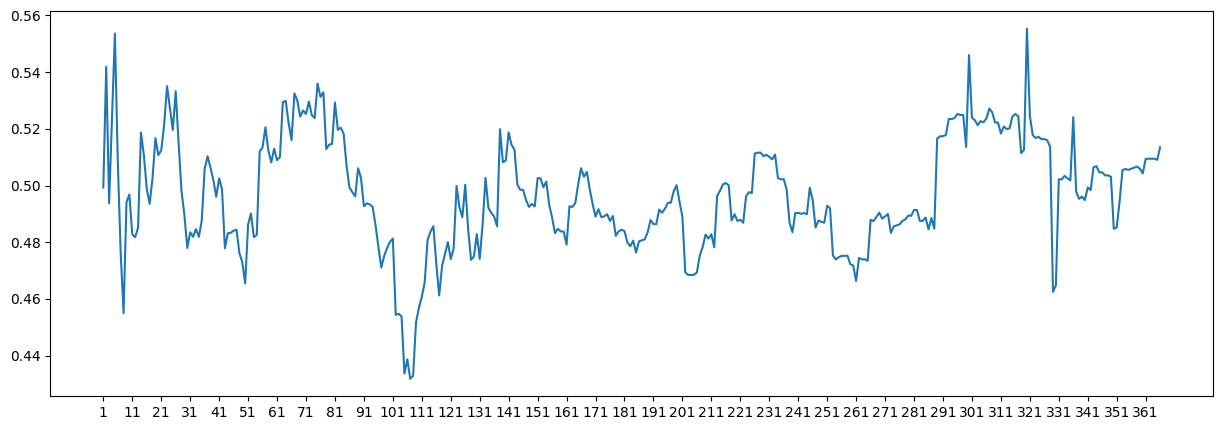

In [20]:
score = []
best_threshold = threshold[0]
best_score = 0

for i in threshold:
  temp_feature = x_train_p01.loc[:, coxPH.coef_[:] >= i]
  temp_coxph = CoxPHSurvivalAnalysis(alpha = 0.01).fit(temp_feature, y_train_struct)
  now_score = my_cross_val(temp_coxph, temp_feature, y_train_struct, ystatus_train, ytime_train, 3)
  score.append(now_score)
  if(now_score > best_score and now_score < 0.9):
    best_score = now_score
    best_threshold = i

max = len(threshold)
score.reverse()
print('best_threshold: ', best_threshold)
print("best_score: ", best_score)
plt.figure(figsize=(15,5))
plt.plot(range(1, max+1), score)
plt.xticks(range(1, max+1, 10))
plt.show()

In [21]:
coxph_x_train_p01 = x_train_p01.loc[:, coxPH.coef_[:] >= -3.943563151376996]
coxph_x_test_p01 = x_test_p01.loc[:, coxPH.coef_[:] >= -3.943563151376996]

/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:176: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:176: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:176: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:176: RuntimeWarning: overflow encountered in exp
  r

efron
0.002
0.53488134412984


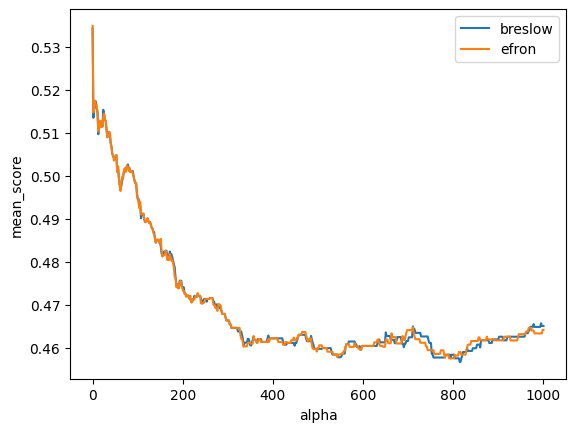

In [29]:
alpha = np.linspace(0.002, 1000, 550)
bre_score = []
efr_score = []
best_score = 0
best_alpha = 0
best_tie = ""

for t in ["breslow", "efron"]:
  for i in alpha:
    cox = CoxPHSurvivalAnalysis(alpha = i, ties = t, n_iter = 200)
    now_score = my_cross_val(cox, coxph_x_train_p01, y_train_struct, ystatus_train, ytime_train, 5)
    if(t == 'breslow'): bre_score.append(now_score)
    else: efr_score.append(now_score)
    
    if(now_score > best_score):
      best_tie = t
      best_score = now_score
      best_alpha = i

print(best_tie)
print(best_alpha)
print(best_score)

plt.plot()
breslow, = plt.plot(alpha, bre_score, label = 'breslow')
efron, = plt.plot(alpha, efr_score, label = 'efron')
plt.xlabel('alpha')
plt.ylabel('mean_score')
plt.legend(handles = [breslow, efron], loc='upper right')
plt.show()

In [30]:
cox = CoxPHSurvivalAnalysis(alpha = 0.002, ties = efron, n_iter = 200)
C_indicator(cox, coxph_x_train_p01, y_train_struct, ystatus_train, ytime_train, coxph_x_test_p01, y_test_struct, ystatus_test, ytime_test)

/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:176: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


           C-index    C-ipcw
training  1.000000  1.000000
test      0.463842  0.434973


/usr/local/lib/python3.10/dist-packages/sksurv/linear_model/coxph.py:81: RuntimeWarning: invalid value encountered in true_divide
  y = np.cumsum(n_events / divisor)


**CGBS**

In [17]:
#去0
cgbs = ComponentwiseGradientBoostingSurvivalAnalysis().fit(x_train_p01, y_train_struct)
cgbs_prefeature = x_train_p01.loc[:, cgbs.coef_[1:] != 0]
cgbs_test_prefeature = x_test_p01.loc[:, cgbs.coef_[1:] != 0]

In [18]:
#取coef
cgbs = ComponentwiseGradientBoostingSurvivalAnalysis().fit(cgbs_prefeature, y_train_struct)
threshold = cgbs.coef_[1:]
threshold.sort()

best_threshold:  0.0651708187969308
best_score:  0.5925983526466508


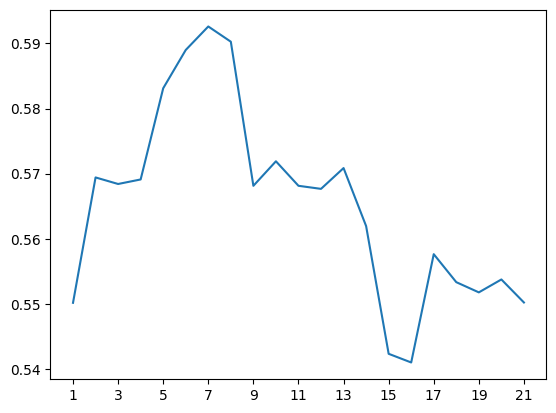

In [19]:
score = []
best_threshold = threshold[0]
best_score = 0

for i in threshold:
  temp_feature = cgbs_prefeature.loc[:, cgbs.coef_[1:] >= i]
  temp_cgbs = ComponentwiseGradientBoostingSurvivalAnalysis().fit(temp_feature, y_train_struct)
  now_score = my_cross_val(temp_cgbs, temp_feature, y_train_struct, ystatus_train, ytime_train, 3)
  score.append(now_score)
  if(now_score > best_score):
    best_score = now_score
    best_threshold = i

max = len(threshold)
score.reverse()
print('best_threshold: ', best_threshold)
print("best_score: ", best_score)
plt.plot(range(1, max+1), score)
plt.xticks(range(1, max+1, 2))
plt.show()

In [20]:
cgbs_x_train_p01 = cgbs_prefeature.loc[:, cgbs.coef_[1:] >= best_threshold]
cgbs_x_test_p01 = cgbs_test_prefeature.loc[:, cgbs.coef_[1:] >= best_threshold]

loss:  coxph
learning rate:  0.5253
best score:  0.6010049890249411


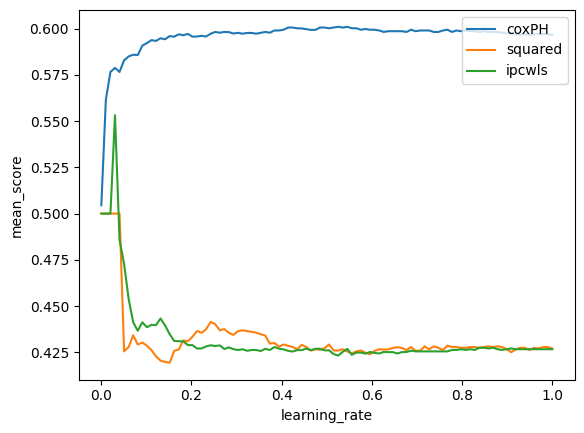

In [21]:
learning_rate = np.linspace(0.0001, 1, 100)
cox_score = []
squ_score = []
ipcw_score = []
best_score = 0
best_rate = 0
best_loss = ""

for l in ['coxph', 'squared', 'ipcwls']:
  for i in learning_rate:
    cgbs = ComponentwiseGradientBoostingSurvivalAnalysis(loss = l, learning_rate = i)
    now_score = my_cross_val(cgbs, cgbs_x_train_p01, y_train_struct, ystatus_train, ytime_train, 3)
    if(l == 'coxph'): cox_score.append(now_score)
    elif(l == 'squared'): squ_score.append(now_score)
    else: ipcw_score.append(now_score)
    
    if(now_score > best_score):
      best_loss = l
      best_score = now_score
      best_rate = i

print('loss: ', best_loss)
print('learning rate: ', best_rate)
print('best score: ', best_score)

plt.plot()
coxph, = plt.plot(learning_rate, cox_score, label = 'coxPH')
squared, = plt.plot(learning_rate, squ_score, label = 'squared')
ipcwls, = plt.plot(learning_rate, ipcw_score, label = 'ipcwls')
plt.xlabel('learning_rate')
plt.ylabel('mean_score')
plt.legend(handles = [coxph, squared, ipcwls], loc='upper right')
plt.show()

In [22]:
cgbs_model = ComponentwiseGradientBoostingSurvivalAnalysis(loss = best_loss, learning_rate = best_rate)
C_indicator(cgbs_model, cgbs_x_train_p01, y_train_struct, ystatus_train, ytime_train, cgbs_x_test_p01, y_test_struct, ystatus_test, ytime_test)

           C-index    C-ipcw
training  0.612842  0.610431
test      0.647188  0.639316


# **KM**

In [23]:
cgbs = ComponentwiseGradientBoostingSurvivalAnalysis(loss = 'coxph', learning_rate = 0.5253).fit(cgbs_x_train_p01, y_train_struct)

In [24]:
feature_importance = pd.DataFrame({
    "feature importance": cgbs.feature_importances_[1:]
})

feature_importance.index=cgbs_x_train_p01.columns
feature_importance.sort_values(by="feature importance", ascending=True)

,feature importance
ENSG00000254622.1,1.0
ENSG00000237975.7,2.0
ENSG00000248469.1,3.0
ENSG00000223466.2,5.0
ENSG00000262061.6,6.0
ENSG00000224758.1,11.0
ENSG00000229628.1,12.0


In [25]:
for i in feature_importance.sort_values(by="feature importance", ascending=True).index:
  print(i)

ENSG00000254622.1
ENSG00000237975.7
ENSG00000248469.1
ENSG00000223466.2
ENSG00000262061.6
ENSG00000224758.1
ENSG00000229628.1


In [26]:
x_km = x.copy()

In [27]:
y_struct = y_label.to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

<ipython-input-8-85c4425bbf24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "High"


          test_statistic         p   -log2(p)
High Low       13.016528  0.000309  11.661256


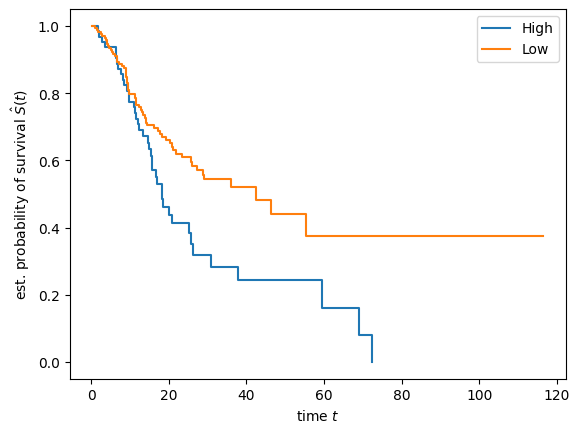

In [28]:
km_logrank('ENSG00000254622.1', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "High"


          test_statistic         p  -log2(p)
High Low        6.225743  0.012591  6.311508


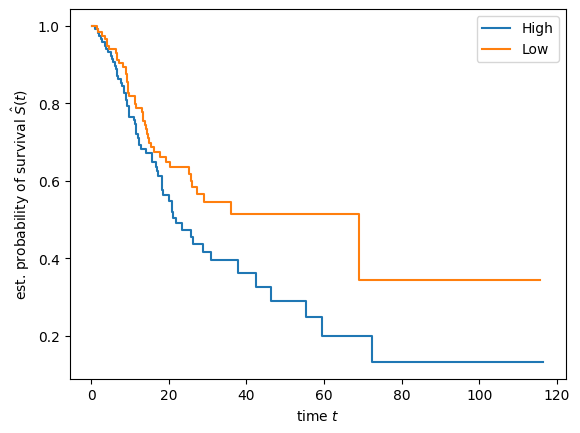

In [29]:
km_logrank('ENSG00000237975.7', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "Low"


          test_statistic         p  -log2(p)
High Low        4.840857  0.027793  5.169131


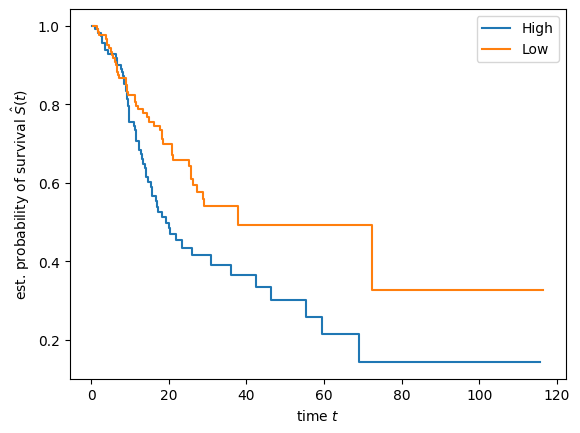

In [30]:
km_logrank('ENSG00000248469.1', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "High"


          test_statistic         p  -log2(p)
High Low         5.00974  0.025205  5.310141


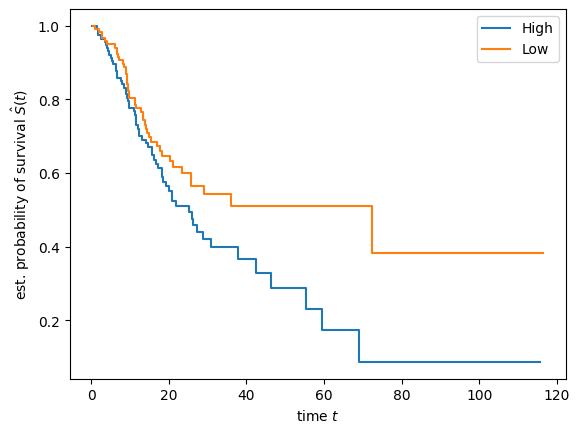

In [31]:
km_logrank('ENSG00000223466.2', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "Low"


          test_statistic         p  -log2(p)
High Low        2.973718  0.084627  3.562735


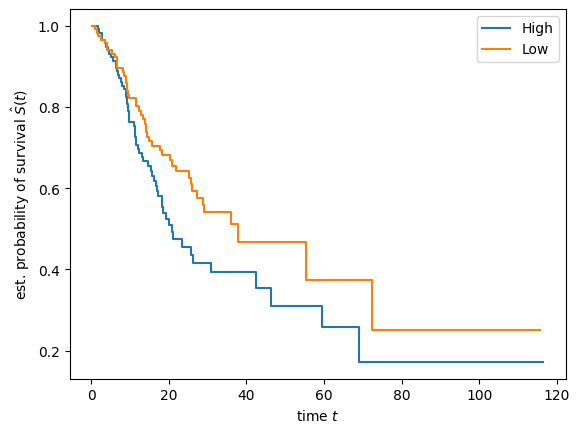

In [32]:
km_logrank('ENSG00000262061.6', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "High"


          test_statistic         p  -log2(p)
High Low        0.717503  0.396964   1.33292


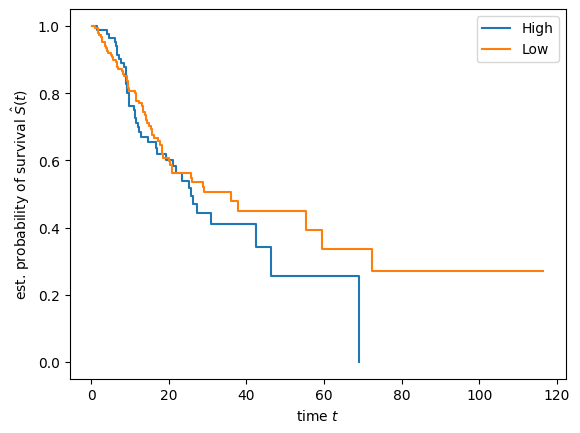

In [33]:
km_logrank('ENSG00000224758.1', x_km, y_struct)

<ipython-input-8-85c4425bbf24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene.loc[i] = "High"


          test_statistic         p  -log2(p)
High Low        0.485602  0.485896  1.041281


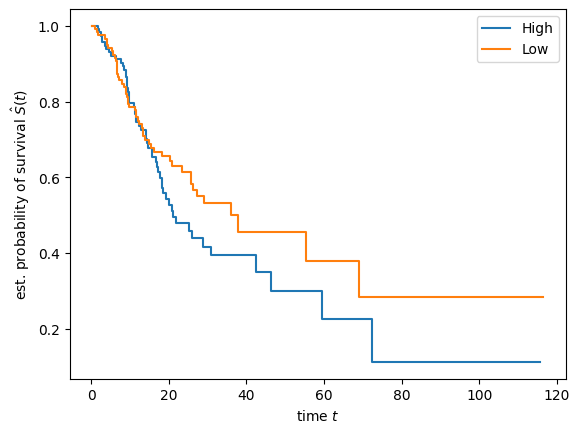

In [34]:
km_logrank('ENSG00000229628.1', x_km, y_struct)

# **Load**

In [35]:
from joblib import dump, load

In [37]:
dump(cgbs_model, 'survival.joblib')

['survival.joblib']

In [42]:
f = cgbs_x_train_p01.columns.to_list()

In [43]:
f = pd.DataFrame(f).T

In [44]:
f

,0,1,2,3,4,5,6
0,ENSG00000223466.2,ENSG00000224758.1,ENSG00000229628.1,ENSG00000237975.7,ENSG00000248469.1,ENSG00000254622.1,ENSG00000262061.6


In [45]:
f.to_csv("/content/drive/MyDrive/features_cox.csv", index = False)